# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                     
Sample_193  Q562R1                                                19.848
Sample_139  P15509;P15509-2;P15509-3;P15509-5;P15509-7;P15509-8   21.025
Sample_097  E7EN65;E7ENM0;P15502-1;P15502-2;P15502-4;P15502-5     15.808
Sample_035  Q9HDB5                                                18.075
Sample_151  C9J8T4;C9JYN7;O43567                                  17.178
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups
Sample_009  Q8NFT8           13.722
Sample_081  B8ZZL8;P61604    15.346
Sample_183  Q14517           13.803
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.522
            A0A075B6Q5                 13.229
            A0A075B6R2                 12.063
            A0A075B6S5                 13.426
            A0A087WSY4                 12.260
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.422
            Q9UI40;Q9UI40-2            13.150
            Q9UIW2                     12.286
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.037
            Q9UP79                     13.988
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.082,15.050,16.842,19.863,15.899,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.524,19.067,...,15.528,15.576,14.062,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.826,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.439,17.705,17.039,16.046,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.633,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.576,15.345,17.084,18.708,14.249,19.433,11.163,11.310
Sample_207,15.739,16.877,15.469,16.898,15.349,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.522,...,16.012,15.178,12.153,15.050,16.842,19.863,13.414,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.568,19.067,16.188,...,15.528,15.576,12.843,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.510,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.425,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.877,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.677,15.345,17.084,18.708,14.249,19.433,12.805,12.668
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 374.52it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

100%|██████████| 2/2 [00:00<00:00,  6.49it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.22it/s]

100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.37it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

100%|██████████| 4/4 [00:00<00:00,  3.82it/s]

100%|██████████| 4/4 [00:00<00:00,  4.20it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.23it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.69it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.33it/s]

100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

100%|██████████| 5/5 [00:01<00:00,  3.47it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.29it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.05it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.31it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.13it/s]

100%|██████████| 6/6 [00:01<00:00,  2.85it/s]

100%|██████████| 6/6 [00:01<00:00,  3.21it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.24it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.20it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.04it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.97it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.02it/s]

100%|██████████| 7/7 [00:03<00:00,  2.33it/s]

100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.83it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.66it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.41it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.48it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.75it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.82it/s]

100%|██████████| 8/8 [00:02<00:00,  2.84it/s]

100%|██████████| 8/8 [00:02<00:00,  2.77it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.24it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.08it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.13it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.71it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.43it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.41it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.59it/s]

100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

100%|██████████| 9/9 [00:03<00:00,  2.72it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.59it/s]

 30%|███       | 3/10 [00:00<00:01,  4.45it/s]

 40%|████      | 4/10 [00:01<00:01,  3.33it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.55it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.10it/s]

 70%|███████   | 7/10 [00:02<00:01,  1.90it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.90it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.83it/s]

100%|██████████| 10/10 [00:04<00:00,  1.97it/s]

100%|██████████| 10/10 [00:04<00:00,  2.25it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.12it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.88it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.86it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.91it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.91it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.88it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.36it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.38it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.27it/s]

100%|██████████| 11/11 [00:04<00:00,  2.27it/s]

100%|██████████| 11/11 [00:04<00:00,  2.56it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.58it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.05it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.79it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.57it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.45it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.41it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.40it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.41it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.40it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.91it/s]

100%|██████████| 12/12 [00:03<00:00,  2.54it/s]

100%|██████████| 12/12 [00:03<00:00,  3.19it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.58it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.19it/s]

 31%|███       | 4/13 [00:00<00:02,  3.86it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.52it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.36it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.22it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.21it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.63it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.35it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.15it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.23it/s]

100%|██████████| 13/13 [00:04<00:00,  2.21it/s]

100%|██████████| 13/13 [00:04<00:00,  2.72it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.79it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.86it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.31it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.72it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.61it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.43it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.36it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.50it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.56it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.64it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.79it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.98it/s]

100%|██████████| 14/14 [00:04<00:00,  3.13it/s]

100%|██████████| 14/14 [00:04<00:00,  2.87it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.41it/s]

 20%|██        | 3/15 [00:01<00:04,  2.53it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.18it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.11it/s]

 40%|████      | 6/15 [00:02<00:04,  2.23it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.26it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.20it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.37it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.47it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.59it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.61it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.74it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.79it/s]

100%|██████████| 15/15 [00:05<00:00,  2.79it/s]

100%|██████████| 15/15 [00:05<00:00,  2.51it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.053 0.022          0.643 0.420       0.092   
2             0.006 0.005      0.058 0.018          0.675 0.122       0.523   
3             0.004 0.002      0.055 0.021          0.717 0.091       0.669   
4             0.005 0.004      0.051 0.011          0.731 0.095       0.717   
5             0.003 0.001      0.040 0.009          0.752 0.099       0.723   
6             0.004 0.000      0.049 0.007          0.742 0.088       0.724   
7             0.004 0.001      0.050 0.011          0.735 0.092       0.725   
8             0.005 0.003      0.066 0.023          0.751 0.081       0.760   
9             0.006 0.006      0.064 0.032          0.801 0.083       0.792   
10            0.006 0.005      0.056 0.017          0.800 0.079       0.804   
11            0.006 0.006      0.068 0.030          0.795 0.080       0.796   
12            0.007 0.006      0.079 0.030          0.795 0.083       0.794   
13            0.007 0.005      0.071 0.029          0.799 0.081       0.792   
14            0.005 0.004      0.057 0.025          0.798 0.083       0.789   
15            0.006 0.005      0.066 0.025          0.803 0.081       0.797   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.154 0.127                  0.538 0.038        0.853   
2          0.111   0.581 0.090                  0.665 0.065        0.718   
3          0.115   0.687 0.089                  0.737 0.070        0.826   
4          0.103   0.720 0.082                  0.760 0.069        0.853   
5          0.104   0.731 0.079                  0.771 0.065        0.850   
6          0.108   0.728 0.080                  0.768 0.065        0.853   
7          0.110   0.725 0.082                  0.765 0.067        0.850   
8          0.105   0.751 0.073                  0.787 0.060        0.857   
9          0.109   0.791 0.071                  0.822 0.058        0.905   
10         0.095   0.798 0.069                  0.827 0.059        0.909   
11         0.094   0.792 0.069                  0.822 0.057        0.909   
12         0.094   0.790 0.069                  0.821 0.057        0.907   
13         0.095   0.792 0.070                  0.823 0.058        0.905   
14         0.096   0.790 0.071                  0.821 0.060        0.905   
15         0.094   0.796 0.068                  0.826 0.057        0.904   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.821 0.089        210.000 0.000  
2          0.081                  0.669 0.101        210.000 0.000  
3          0.059                  0.769 0.087        210.000 0.000  
4          0.056                  0.812 0.080        210.000 0.000  
5          0.055                  0.803 0.079        210.000 0.000  
6          0.052                  0.801 0.075        210.000 0.000  
7          0.053                  0.796 0.075        210.000 0.000  
8          0.055                  0.815 0.075        210.000 0.000  
9          0.048                  0.877 0.064        210.000 0.000  
10         0.049                  0.892 0.054        210.000 0.000  
11         0.049                  0.893 0.053        210.000 0.000  
12         0.050                  0.891 0.054        210.000 0.000  
13         0.051                  0.888 0.057        210.000 0.000  
14         0.051                  0.888 0.058        210.000 0.000  
15         0.051                  0.886 0.058 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 461.98it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

100%|██████████| 2/2 [00:00<00:00,  5.77it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.26it/s]

100%|██████████| 3/3 [00:00<00:00,  3.69it/s]

100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.39it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.37it/s]

100%|██████████| 4/4 [00:01<00:00,  2.95it/s]

100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.23it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.75it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.83it/s]

100%|██████████| 5/5 [00:01<00:00,  3.44it/s]

100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.38it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.21it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.50it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.38it/s]

100%|██████████| 6/6 [00:01<00:00,  3.17it/s]

100%|██████████| 6/6 [00:01<00:00,  3.55it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.48it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.74it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.90it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.77it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.88it/s]

100%|██████████| 7/7 [00:02<00:00,  3.02it/s]

100%|██████████| 7/7 [00:02<00:00,  2.95it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.31it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.87it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.28it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.32it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.81it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.46it/s]

100%|██████████| 8/8 [00:02<00:00,  3.33it/s]

100%|██████████| 8/8 [00:02<00:00,  3.83it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.17it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.89it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.57it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.17it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.72it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.36it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.17it/s]

100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

100%|██████████| 9/9 [00:03<00:00,  2.69it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.10it/s]

 30%|███       | 3/10 [00:00<00:02,  3.02it/s]

 40%|████      | 4/10 [00:01<00:02,  2.91it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.75it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.64it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.75it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.86it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.88it/s]

100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.91it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.47it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.38it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.89it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.99it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.71it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.38it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.21it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.33it/s]

100%|██████████| 11/11 [00:04<00:00,  2.03it/s]

100%|██████████| 11/11 [00:04<00:00,  2.63it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.65it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.45it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.83it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.49it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.36it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.04it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.87it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  1.81it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.93it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.02it/s]

100%|██████████| 12/12 [00:05<00:00,  2.05it/s]

100%|██████████| 12/12 [00:05<00:00,  2.31it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.52it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.83it/s]

 31%|███       | 4/13 [00:01<00:03,  2.99it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.44it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.40it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.44it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.51it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.76it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.72it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.69it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.67it/s]

100%|██████████| 13/13 [00:04<00:00,  2.65it/s]

100%|██████████| 13/13 [00:04<00:00,  2.77it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.57it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.54it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.38it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.19it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.10it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.02it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.02it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.98it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.96it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.92it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.99it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.10it/s]

100%|██████████| 14/14 [00:04<00:00,  3.10it/s]

100%|██████████| 14/14 [00:04<00:00,  3.13it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.59it/s]

 20%|██        | 3/15 [00:00<00:02,  4.84it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.13it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.92it/s]

 40%|████      | 6/15 [00:01<00:02,  3.80it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.54it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.71it/s]

 60%|██████    | 9/15 [00:02<00:01,  4.03it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.24it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.17it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.22it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  4.23it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.21it/s]

100%|██████████| 15/15 [00:03<00:00,  4.32it/s]

100%|██████████| 15/15 [00:03<00:00,  4.19it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.061 0.026          0.013 0.094       0.002   
2             0.005 0.003      0.061 0.023          0.664 0.268       0.191   
3             0.004 0.002      0.050 0.012          0.676 0.105       0.605   
4             0.005 0.003      0.054 0.015          0.681 0.096       0.616   
5             0.004 0.002      0.057 0.018          0.719 0.101       0.665   
6             0.003 0.001      0.036 0.014          0.754 0.098       0.682   
7             0.003 0.000      0.033 0.018          0.775 0.092       0.762   
8             0.005 0.004      0.061 0.021          0.780 0.086       0.760   
9             0.004 0.000      0.048 0.005          0.770 0.093       0.756   
10            0.004 0.001      0.055 0.017          0.769 0.092       0.763   
11            0.005 0.004      0.062 0.031          0.801 0.090       0.781   
12            0.003 0.002      0.040 0.020          0.783 0.088       0.779   
13            0.003 0.001      0.030 0.008          0.793 0.091       0.788   
14            0.003 0.002      0.039 0.020          0.798 0.092       0.797   
15            0.003 0.001      0.044 0.016          0.795 0.093       0.793   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.017   0.004 0.028                  0.497 0.010        0.860   
2          0.094   0.288 0.125                  0.564 0.043        0.692   
3          0.102   0.634 0.087                  0.695 0.067        0.786   
4          0.097   0.643 0.085                  0.701 0.065        0.779   
5          0.112   0.686 0.091                  0.736 0.072        0.802   
6          0.088   0.711 0.075                  0.757 0.061        0.839   
7          0.112   0.763 0.075                  0.798 0.063        0.898   
8          0.114   0.764 0.073                  0.800 0.059        0.897   
9          0.114   0.756 0.076                  0.793 0.062        0.894   
10         0.109   0.759 0.071                  0.795 0.059        0.895   
11         0.111   0.785 0.076                  0.817 0.063        0.906   
12         0.112   0.775 0.074                  0.808 0.062        0.905   
13         0.102   0.784 0.066                  0.816 0.056        0.915   
14         0.096   0.792 0.069                  0.822 0.058        0.917   
15         0.099   0.789 0.068                  0.819 0.057        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.826 0.089        210.000 0.000  
2          0.104                  0.660 0.105        210.000 0.000  
3          0.067                  0.736 0.097        210.000 0.000  
4          0.066                  0.728 0.096        210.000 0.000  
5          0.066                  0.775 0.087        210.000 0.000  
6          0.059                  0.803 0.077        210.000 0.000  
7          0.049                  0.869 0.061        210.000 0.000  
8          0.049                  0.867 0.062        210.000 0.000  
9          0.050                  0.866 0.060        210.000 0.000  
10         0.050                  0.869 0.058        210.000 0.000  
11         0.047                  0.882 0.055        210.000 0.000  
12         0.048                  0.881 0.057        210.000 0.000  
13         0.044                  0.894 0.051        210.000 0.000  
14         0.043                  0.898 0.050        210.000 0.000  
15         0.044                  0.895 0.051 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 926.30it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 42.70it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 30.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 20.05it/s]

100%|██████████| 4/4 [00:00<00:00, 19.41it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 15.12it/s]

100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

100%|██████████| 5/5 [00:00<00:00, 13.14it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 26.67it/s]

100%|██████████| 6/6 [00:00<00:00, 17.82it/s]

100%|██████████| 6/6 [00:00<00:00, 18.71it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 26.51it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 23.54it/s]

100%|██████████| 7/7 [00:00<00:00, 23.46it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 21.27it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 16.64it/s]

100%|██████████| 8/8 [00:00<00:00, 17.94it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 27.11it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 21.79it/s]

100%|██████████| 9/9 [00:00<00:00, 21.35it/s]

100%|██████████| 9/9 [00:00<00:00, 21.85it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 24.44it/s]

 60%|██████    | 6/10 [00:00<00:00, 19.47it/s]

 90%|█████████ | 9/10 [00:00<00:00, 18.83it/s]

100%|██████████| 10/10 [00:00<00:00, 19.57it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 29.32it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 24.31it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 21.01it/s]

100%|██████████| 11/11 [00:00<00:00, 21.71it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 26.88it/s]

 50%|█████     | 6/12 [00:00<00:00, 20.44it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 19.61it/s]

100%|██████████| 12/12 [00:00<00:00, 20.51it/s]

100%|██████████| 12/12 [00:00<00:00, 20.68it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 29.16it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 22.94it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 16.86it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 17.04it/s]

100%|██████████| 13/13 [00:00<00:00, 18.31it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 27.82it/s]

 43%|████▎     | 6/14 [00:00<00:00, 23.74it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 22.62it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 21.21it/s]

100%|██████████| 14/14 [00:00<00:00, 21.90it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 28.94it/s]

 47%|████▋     | 7/15 [00:00<00:00, 25.45it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 23.07it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 22.43it/s]

100%|██████████| 15/15 [00:00<00:00, 23.28it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.035 0.010          0.000 0.000       0.000   
2             0.003 0.002      0.040 0.020          0.687 0.190       0.260   
3             0.003 0.001      0.040 0.012          0.618 0.195       0.243   
4             0.002 0.000      0.027 0.001          0.680 0.092       0.576   
5             0.003 0.001      0.040 0.012          0.686 0.091       0.609   
6             0.003 0.002      0.033 0.011          0.685 0.098       0.597   
7             0.004 0.003      0.045 0.024          0.679 0.096       0.592   
8             0.003 0.001      0.037 0.010          0.673 0.085       0.582   
9             0.003 0.001      0.029 0.006          0.672 0.089       0.578   
10            0.003 0.000      0.029 0.006          0.685 0.087       0.586   
11            0.003 0.000      0.029 0.006          0.684 0.090       0.588   
12            0.003 0.002      0.030 0.010          0.696 0.091       0.612   
13            0.002 0.000      0.028 0.003          0.685 0.085       0.607   
14            0.003 0.001      0.030 0.005          0.682 0.087       0.605   
15            0.003 0.001      0.031 0.006          0.676 0.081       0.613   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.739   
2          0.084   0.363 0.091                  0.577 0.047        0.600   
3          0.084   0.335 0.095                  0.556 0.052        0.589   
4          0.108   0.616 0.080                  0.686 0.058        0.770   
5          0.115   0.639 0.088                  0.702 0.064        0.788   
6          0.116   0.631 0.090                  0.697 0.066        0.785   
7          0.115   0.626 0.090                  0.692 0.066        0.781   
8          0.117   0.617 0.085                  0.687 0.061        0.777   
9          0.114   0.615 0.087                  0.685 0.064        0.775   
10         0.105   0.624 0.077                  0.692 0.057        0.773   
11         0.101   0.627 0.083                  0.694 0.062        0.788   
12         0.107   0.645 0.085                  0.707 0.064        0.802   
13         0.106   0.638 0.081                  0.700 0.060        0.798   
14         0.104   0.635 0.079                  0.698 0.060        0.793   
15         0.103   0.638 0.078                  0.698 0.060        0.791   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.688 0.085        210.000 0.000  
2          0.071                  0.585 0.067        210.000 0.000  
3          0.069                  0.568 0.064        210.000 0.000  
4          0.057                  0.730 0.065        210.000 0.000  
5          0.061                  0.749 0.069        210.000 0.000  
6          0.062                  0.746 0.067        210.000 0.000  
7          0.062                  0.739 0.071        210.000 0.000  
8          0.061                  0.736 0.069        210.000 0.000  
9          0.061                  0.733 0.069        210.000 0.000  
10         0.061                  0.734 0.069        210.000 0.000  
11         0.059                  0.745 0.068        210.000 0.000  
12         0.058                  0.753 0.070        210.000 0.000  
13         0.058                  0.749 0.069        210.000 0.000  
14         0.059                  0.742 0.070        210.000 0.000  
15         0.060                  0.741 0.072 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,1,7
score_time,12,11,7
test_precision,15,11,12
test_recall,10,14,15
test_f1,10,14,12
test_balanced_accuracy,10,14,12
test_roc_auc,10,14,12
test_average_precision,11,14,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.50it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.44it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.62it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.30it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.22it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.27it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.28it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.38it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.39it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.44it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.43it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.41it/s]

100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

100%|██████████| 14/14 [00:03<00:00,  4.54it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 21.12it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 17.31it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 17.95it/s]

100%|██████████| 12/12 [00:00<00:00, 19.28it/s]

100%|██████████| 12/12 [00:00<00:00, 18.88it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 10.25it/s]

 40%|████      | 4/10 [00:00<00:00,  6.52it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.84it/s]

 60%|██████    | 6/10 [00:00<00:00,  5.66it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.54it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.45it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.34it/s]

100%|██████████| 10/10 [00:01<00:00,  4.55it/s]

100%|██████████| 10/10 [00:01<00:00,  5.39it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


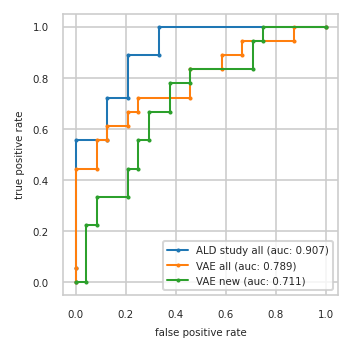

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.556   0.000 0.444   0.042 0.222
3          0.125 0.556   0.083 0.444   0.083 0.222
4          0.125 0.722   0.083 0.556   0.083 0.333
5          0.208 0.722   0.125 0.556   0.208 0.333
6          0.208 0.889   0.125 0.611   0.208 0.444
7          0.333 0.889   0.208 0.611   0.250 0.444
8          0.333 1.000   0.208 0.667   0.250 0.556
9          1.000 1.000   0.250 0.667   0.292 0.556
10           NaN   NaN   0.250 0.722   0.292 0.667
11           NaN   NaN   0.458 0.722   0.375 0.667
12           NaN   NaN   0.458 0.833   0.375 0.778
13           NaN   NaN   0.583 0.833   0.458 0.778
14           NaN   NaN   0.583 0.889   0.458 0.833
15           NaN   NaN   0.667 0.889   0.708 0.833
16           NaN   NaN   0.667 0.944   0.708 0.944
17           NaN   NaN   0.875 0.944   0.750 0.944
18           NaN   NaN   0.875 1.000   0.750 1.000
19           NaN   NaN   1.000 1.000   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q8NBI6,Q99983,P51688
2,Q16674;W4VSR3,Q8NFY4;Q8NFY4-6,P36269;P36269-2;P36269-3
3,P04075,P09104,P31321
4,P14174,P61981,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
5,P61981,Q9Y2T3;Q9Y2T3-3,E9PK25;G3V1A4;P23528
6,Q9Y2T3;Q9Y2T3-3,P04075,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,P00338;P00338-3,P14174,Q96GD0
8,Q6EMK4,Q14894,A0A075B7B8


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


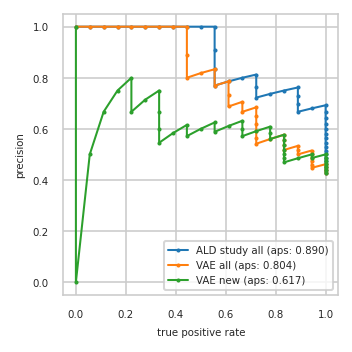

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.447 0.944     0.474 1.000
5          0.486 1.000     0.459 0.944     0.486 1.000
6          0.500 1.000     0.472 0.944     0.500 1.000
7          0.514 1.000     0.486 0.944     0.486 0.944
8          0.529 1.000     0.500 0.944     0.500 0.944
9          0.545 1.000     0.515 0.944     0.485 0.889
10         0.562 1.000     0.500 0.889     0.469 0.833
11         0.581 1.000     0.516 0.889     0.484 0.833
12         0.600 1.000     0.533 0.889     0.500 0.833
13         0.621 1.000     0.517 0.833     0.517 0.833
14         0.643 1.000     0.536 0.833     0.536 0.833
15         0.667 1.000     0.556 0.833     0.556 0.833
16         0.692 1.000     0.577 0.833     0.577 0.833
17         0.680 0.944     0.560 0.778     0.560 0.778
18         0.667 0.889     0.542 0.722     0.583 0.778
19         0.696 0.889     0.565 0.722     0.609 0.778
20         0.727 0.889     0.591 0.722     0.591 0.722
21         0.762 0.889     0.619 0.722     0.571 0.667
22         0.750 0.833     0.650 0.722     0.600 0.667
23         0.737 0.778     0.684 0.722     0.632 0.667
24         0.722 0.722     0.667 0.667     0.611 0.611
25         0.765 0.722     0.706 0.667     0.588 0.556
26         0.812 0.722     0.688 0.611     0.625 0.556
27         0.800 0.667     0.733 0.611     0.600 0.500
28         0.786 0.611     0.786 0.611     0.571 0.444
29         0.769 0.556     0.769 0.556     0.615 0.444
30         0.833 0.556     0.833 0.556     0.583 0.389
31         0.909 0.556     0.818 0.500     0.545 0.333
32         1.000 0.556     0.800 0.444     0.600 0.333
33         1.000 0.500     0.889 0.444     0.667 0.333
34         1.000 0.444     1.000 0.444     0.750 0.333
35         1.000 0.389     1.000 0.389     0.714 0.278
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


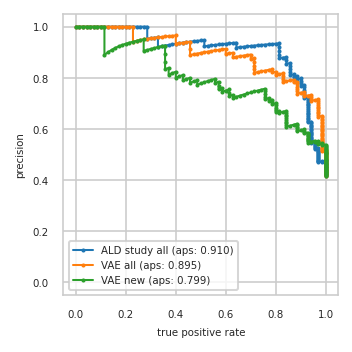

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


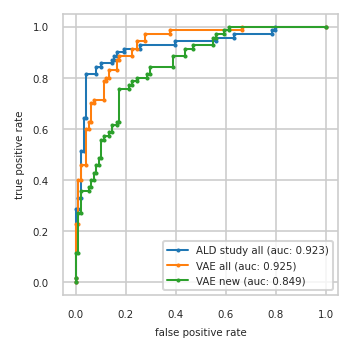

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}